# PART2 決定木のモデルを作ってみよう

## おまじない
- 以下を追加します
    - from sklearn.tree import DecisionTreeClassifier as DT
    - from sklearn.tree import export_graphviz
    - import pydotplus
    - from IPython.display import Image

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image

## データの読み込み
- train.csvとtest.csvとsubmit_sample.csvの３つのファイルを読み込みましょう
- それぞれを読み込んだものは変数はtrain, test, sampleに代入しましょう
- submit_sampleを読み込む時は、header=Noneというオプションを忘れないようにしましょう

In [5]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
sample = pd.read_csv('input/submit_sample.csv', header=None)

## trainの先頭行を確認してみましょう

In [6]:
train.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,1,39,blue-collar,married,secondary,no,1756,yes,no,cellular,3,apr,939,1,-1,0,unknown,1
1,2,51,entrepreneur,married,primary,no,1443,no,no,cellular,18,feb,172,10,-1,0,unknown,1
2,3,36,management,single,tertiary,no,436,no,no,cellular,13,apr,567,1,595,2,failure,1
3,4,63,retired,married,secondary,no,474,no,no,cellular,25,jan,423,1,-1,0,unknown,1
4,5,31,management,single,tertiary,no,354,no,no,cellular,30,apr,502,1,9,2,success,1


## trainから説明変数になるデータを取り出しましょう
- 今回は説明変数はy以外の全てのカラムとしますが、データを選択時に全て書きだすのは面倒です
- そこで今回はilocを使い、選択したデータを変数trainXに代入しましょう
- train.iloc[ 開始行:終了行, 開始列:終了列 ]と書くことで、列・行を数字で指定して書くことができます
- 開始から終了まで全てを取り出したい場合は、「:」だけでよく、数字を省略することも可能です

In [7]:
trainX = train.iloc[:, 0:17]

In [8]:
trainX.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,1,39,blue-collar,married,secondary,no,1756,yes,no,cellular,3,apr,939,1,-1,0,unknown
1,2,51,entrepreneur,married,primary,no,1443,no,no,cellular,18,feb,172,10,-1,0,unknown
2,3,36,management,single,tertiary,no,436,no,no,cellular,13,apr,567,1,595,2,failure
3,4,63,retired,married,secondary,no,474,no,no,cellular,25,jan,423,1,-1,0,unknown
4,5,31,management,single,tertiary,no,354,no,no,cellular,30,apr,502,1,9,2,success


## trainから目的変数になるデータを取り出しましょう
- yを選択し、変数yに代入しましょう

In [9]:
y = train['y']

## testの先頭行を見てみましょう

In [10]:
test.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,1,30,management,single,tertiary,no,1028,no,no,cellular,4,feb,1294,2,-1,0,unknown
1,2,39,self-employed,single,tertiary,no,426,no,no,unknown,18,jun,1029,1,-1,0,unknown
2,3,38,technician,single,tertiary,no,-572,yes,yes,unknown,5,jun,26,24,-1,0,unknown
3,4,34,technician,single,secondary,no,-476,yes,no,unknown,27,may,92,4,-1,0,unknown
4,5,37,entrepreneur,married,primary,no,62,no,no,cellular,31,jul,404,2,-1,0,unknown


## testから説明変数となるデータを取り出しましょう
- 今回はtestの全てのカラムが説明変数となりますので、copy関数を使って変数testXに代入します
- 単純にtextX = testとしない理由は今回は説明しませんが、プログラム的な観点の為です

In [11]:
testX = test.copy()

## trainXとtestXをダミー変数化しましょう

In [12]:
trainX = pd.get_dummies(trainX)
testX = pd.get_dummies(testX)

In [13]:
trainX.head()

,id,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,1,39,1756,3,939,1,-1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,2,51,1443,18,172,10,-1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,3,36,436,13,567,1,595,2,0,0,...,0,0,0,0,0,0,1,0,0,0
3,4,63,474,25,423,1,-1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,5,31,354,30,502,1,9,2,0,0,...,0,0,0,0,0,0,0,0,1,0


## 決定木モデルの箱を用意しましょう
- 変数名をclf1とし、DT()を代入しましょう
- DTのカッコの中にはオプションとして機械学習のパラメータを書きます。今回はmax_depth=2, min_samples_leaf=500と書きましょう

In [15]:
clf1 = DT(max_depth=2, min_samples_leaf=500)

## 決定木モデルを作りましょう
- fit関数を使います
- カッコの中に、説明変数、目的変数の順番に書きます

In [16]:
clf1.fit(trainX, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=500, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

## できた木を確認しましょう
- 決定木を可視化する為には、まず決定木の図データをdotファイルで書き出し、その後、jupyter上で表示する必要があります
- まずdotファイル書き出しにはexport_graphviz関数を使います
- export_graphviz(clf1, out_file="tree.dot", feature_names=trainX.columns, class_names=["0","1"], filled=True, rounded=True)と書きましょう

In [18]:
export_graphviz(clf1, out_file='output/tree.dot', feature_names=trainX.columns, class_names=['0','1'], filled=True, rounded=True )

- 書き出せたら、下記の２行を書きます
- g = pydotplus.graph_from_dot_file(path="tree.dot")
- Image(g.create_png())

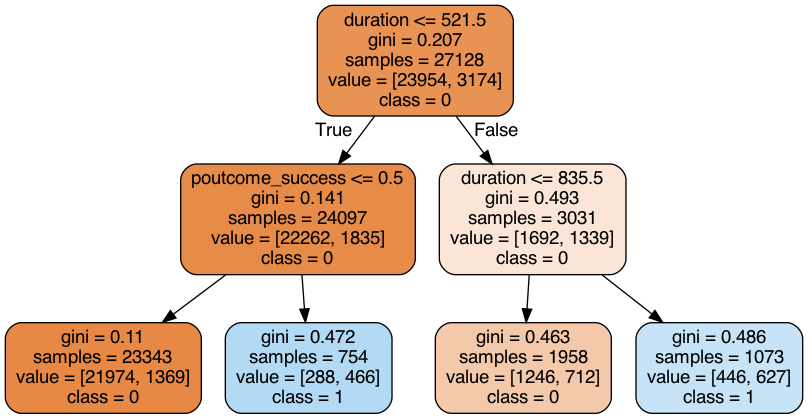

In [20]:
g = pydotplus.graph_from_dot_file(path='output/tree.dot')
Image(g.create_png())

## testを予測しましょう
- 今回は1である確率を出す必要があるので、predict_proba関数を使います
- 予測結果は変数predに代入します
- predにはそれぞれの行の[ 0である確率、1である確率 ]が入っているので、pred[;,1]として1である確率のみを抜き出します

In [21]:
pred = clf1.predict_proba(testX)

In [24]:
pred = pred[:, 1]

In [25]:
pred

array([0.58434296, 0.58434296, 0.05864713, ..., 0.05864713, 0.05864713,
       0.05864713])

## predをsample[1]に代入してファイル出力し、DeepAnalyticsへ投稿しましょう
- ファイル名は「submit1_bank.csv」としましょう
- index=None,header=Noneのオプションを忘れないように書きだしましょう

In [26]:
sample[1] = pred

In [27]:
sample.to_csv('output/submit1_bank.csv', index=None, header=None)

# 実習
1.決定木のパラメータを今度はmax_depth=4, min_samples_leaf=500に変更してもう一度、決定木の箱を用意しよう
- 新しく作るモデルは変数clf2としよう

In [28]:
clf2 = DT(max_depth=4, min_samples_leaf=500)

2.trainXとyを使って決定木のモデルを作ろう

In [29]:
clf2.fit(trainX, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=500, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

3.作ったモデルを可視化してみよう
- モデルをclf2とし、tree2.dotというファイル名で書きだそう

In [30]:
export_graphviz(clf1, out_file='output/tree2.dot', feature_names=trainX.columns, class_names=['0','1'], filled=True, rounded=True )

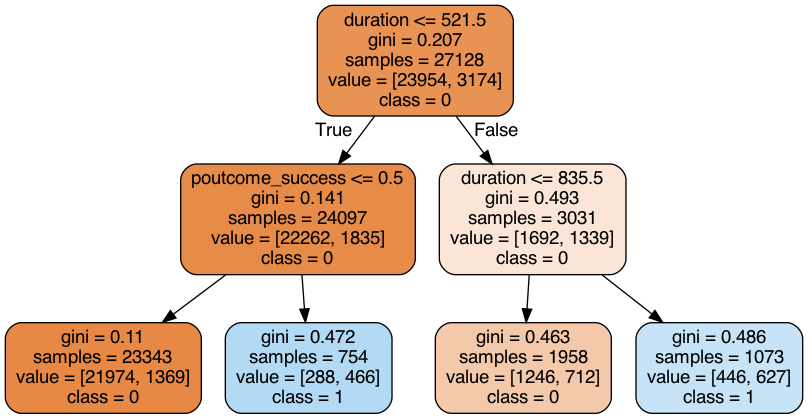

In [31]:
g = pydotplus.graph_from_dot_file(path='output/tree2.dot')
Image(g.create_png())

4.testを予測しましょう
- 予測結果は変数pred2に代入し、1の確率だけを選択して、再度代入しよう

In [32]:
pred2 = clf2.predict_proba(testX)

In [33]:
pred2 = pred2[:, 1]

5.pred2をsample[1]に代入してファイル出力し、DeepAnalyticsへ投稿しましょう
- ファイル名はsubmit2_bank.csvにしよう

In [36]:
sample[1] = pred2

In [37]:
sample.to_csv('output/submit2_bank.csv', index=None, header=None)